In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
from collections import Counter

import mediapipe as mp
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from keras.applications import MobileNetV2
from keras.applications.mobilenet_v2 import preprocess_input
from keras.preprocessing.image import img_to_array


In [2]:
# --- Check dataset integrity ---
data_dir = "FER2013"
classes = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

for split in ["train", "test"]:
    print(f"\nChecking {split} set:")
    for cls in classes:
        path = os.path.join(data_dir, split, cls)
        if os.path.exists(path):
            print(f"{cls}: {len(os.listdir(path))} images")
        else:
            print(f"{cls} folder missing!")


Checking train set:
angry: 3995 images
disgust: 436 images
fear: 4097 images
happy: 7215 images
sad: 4830 images
surprise: 3171 images
neutral: 4965 images

Checking test set:
angry: 958 images
disgust: 111 images
fear: 1024 images
happy: 1774 images
sad: 1247 images
surprise: 831 images
neutral: 1233 images


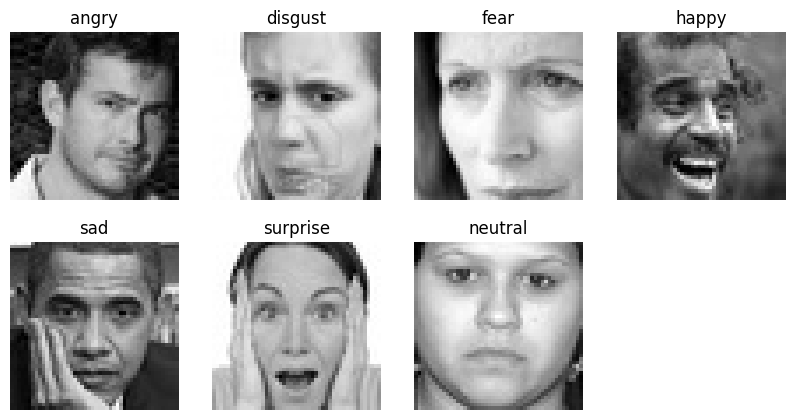

In [3]:
plt.figure(figsize=(10,5))
for i, cls in enumerate(classes):
    img_path = os.path.join(data_dir, "train", cls, os.listdir(os.path.join(data_dir, "train", cls))[1])
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    plt.subplot(2, 4, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(cls)
    plt.axis('off')
plt.show()

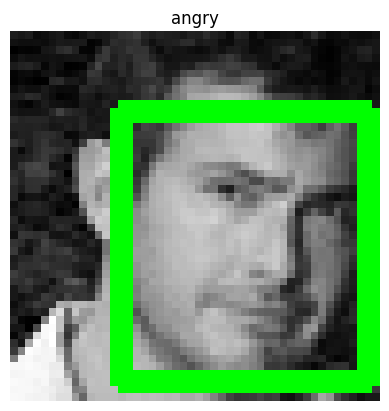

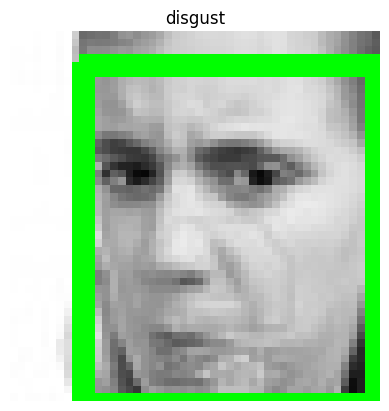

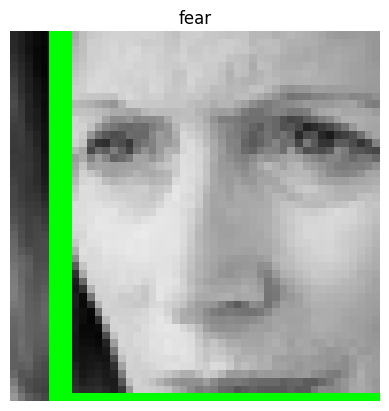

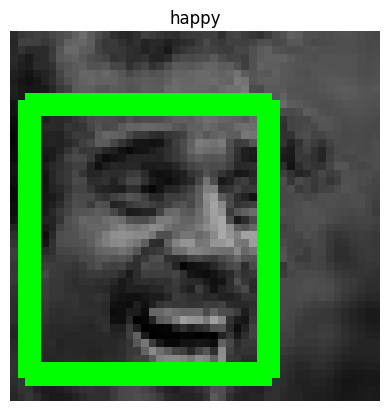

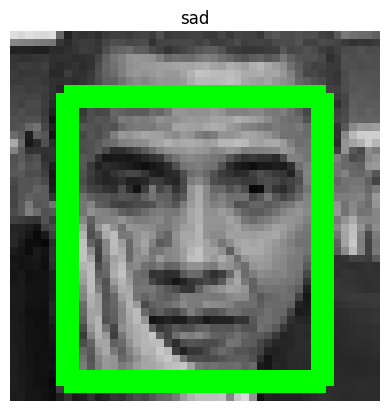

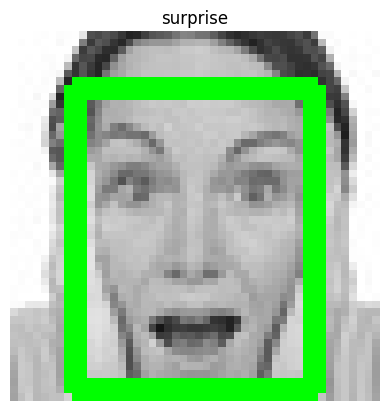

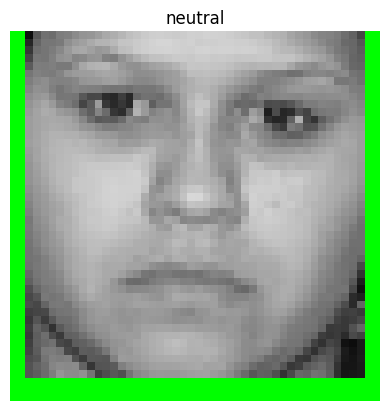

In [4]:
# --- Milestone 1: Face Detection & Visual Check ---
mp_face = mp.solutions.face_mesh
mp_drawing = mp.solutions.drawing_utils

face_mesh = mp_face.FaceMesh(static_image_mode=True, max_num_faces=1)

def detect_face(img):
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(img_rgb)
    if results.multi_face_landmarks:
        h, w = img.shape[:2]
        # Get bounding box around landmarks
        x_min = w; y_min = h; x_max = 0; y_max = 0
        for lm in results.multi_face_landmarks[0].landmark:
            x, y = int(lm.x*w), int(lm.y*h)
            x_min, y_min = min(x_min, x), min(y_min, y)
            x_max, y_max = max(x_max, x), max(y_max, y)
        return x_min, y_min, x_max, y_max
    return None

# Visual check for a few samples
for cls in classes:
    sample_path = os.path.join(data_dir, "train", cls, os.listdir(os.path.join(data_dir, "train", cls))[1])
    img = cv2.imread(sample_path)
    bbox = detect_face(img)
    if bbox:
        x1, y1, x2, y2 = bbox
        cv2.rectangle(img, (x1, y1), (x2, y2), (0,255,0), 2)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(cls)
    plt.axis('off')
    plt.show()

In [5]:
# --- TRACK A: Landmark Features Extraction --- #
def extract_landmark_features(img):
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(img_rgb)
    if results.multi_face_landmarks:
        lm_list = results.multi_face_landmarks[0].landmark
        coords = np.array([[lm.x, lm.y] for lm in lm_list])
        left_eye = coords[33]; right_eye = coords[263]
        center = (left_eye + right_eye) / 2
        scale = np.linalg.norm(left_eye - right_eye)
        norm_coords = (coords - center) / scale
        return norm_coords.flatten()
    return None

def extract_landmark_dataset(folder_path):
    X, y = [], []
    image_paths = []

    # First, collect all image paths
    for cls in classes:
        folder = os.path.join(folder_path, cls)
        for file in os.listdir(folder):
            image_paths.append((os.path.join(folder, file), cls))
    
    print(f"Total images to process: {len(image_paths)}")

    # Process images with progress
    for idx, (img_path, cls) in enumerate(image_paths):
        img = cv2.imread(img_path)
        feat = extract_landmark_features(img)
        if feat is not None:
            X.append(feat)
            y.append(cls)
        if (idx+1) % 50 == 0 or (idx+1) == len(image_paths):
            print(f"Processed {idx+1} / {len(image_paths)} images...")

    X = np.array(X)
    y = np.array(y)
    print(f"Final Landmark dataset shape: X={X.shape}, y={y.shape}")
    return X, y

# Train and Test
X_train_landmark, y_train_landmark = extract_landmark_dataset(os.path.join(data_dir, "train"))
X_test_landmark, y_test_landmark = extract_landmark_dataset(os.path.join(data_dir, "test"))

# Save
np.save('X_train_landmark.npy', X_train_landmark)
np.save('y_train_landmark.npy', y_train_landmark)
np.save('X_test_landmark.npy', X_test_landmark)
np.save('y_test_landmark.npy', y_test_landmark)


Total images to process: 28709
Processed 50 / 28709 images...
Processed 100 / 28709 images...
Processed 150 / 28709 images...
Processed 200 / 28709 images...
Processed 250 / 28709 images...
Processed 300 / 28709 images...
Processed 350 / 28709 images...
Processed 400 / 28709 images...
Processed 450 / 28709 images...
Processed 500 / 28709 images...
Processed 550 / 28709 images...
Processed 600 / 28709 images...
Processed 650 / 28709 images...
Processed 700 / 28709 images...
Processed 750 / 28709 images...
Processed 800 / 28709 images...
Processed 850 / 28709 images...
Processed 900 / 28709 images...
Processed 950 / 28709 images...
Processed 1000 / 28709 images...
Processed 1050 / 28709 images...
Processed 1100 / 28709 images...
Processed 1150 / 28709 images...
Processed 1200 / 28709 images...
Processed 1250 / 28709 images...
Processed 1300 / 28709 images...
Processed 1350 / 28709 images...
Processed 1400 / 28709 images...
Processed 1450 / 28709 images...
Processed 1500 / 28709 images...

In [6]:
# --- TRACK B: CNN Features Extraction (GPU-friendly) --- #
cnn_model = MobileNetV2(weights='imagenet', include_top=False, pooling='avg', input_shape=(224,224,3))

def extract_cnn_features(img):
    if len(img.shape) == 2:  # grayscale
        img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    else:
        img_rgb = img.copy()
    img_resized = cv2.resize(img_rgb, (224,224))
    x = img_to_array(img_resized)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    features = cnn_model.predict(x, verbose=0)
    return features.flatten()

def extract_cnn_dataset(folder_path, batch_size=128):
    X, y = [], []
    image_paths, labels = [], []

    # Collect all image paths first
    for cls in classes:
        folder = os.path.join(folder_path, cls)
        for file in os.listdir(folder):
            image_paths.append(os.path.join(folder, file))
            labels.append(cls)

    print(f"Total images to process: {len(image_paths)}")

    # Process in batches
    for i in range(0, len(image_paths), batch_size):
        batch_paths = image_paths[i:i+batch_size]
        batch_imgs = []
        for img_path in batch_paths:
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img_resized = cv2.resize(img, (224,224))
            img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_GRAY2RGB)
            batch_imgs.append(img_rgb)

        batch_array = np.array(batch_imgs, dtype='float32')
        batch_array = preprocess_input(batch_array)
        feats = cnn_model.predict(batch_array, verbose=0)
        X.extend(feats)
        y.extend(labels[i:i+batch_size])

        # Print progress every batch
        print(f"Processed {i+len(batch_paths)} / {len(image_paths)} images...")

    X = np.array(X)
    y = np.array(y)
    print(f"Final CNN dataset shape: X={X.shape}, y={y.shape}")
    return X, y

# Train and Test CNN Features
X_train_cnn, y_train_cnn = extract_cnn_dataset(os.path.join(data_dir, "train"))
X_test_cnn, y_test_cnn = extract_cnn_dataset(os.path.join(data_dir, "test"))

# Save
np.save('X_train_cnn.npy', X_train_cnn)
np.save('y_train_cnn.npy', y_train_cnn)
np.save('X_test_cnn.npy', X_test_cnn)
np.save('y_test_cnn.npy', y_test_cnn)


Total images to process: 28709
Processed 128 / 28709 images...
Processed 256 / 28709 images...
Processed 384 / 28709 images...
Processed 512 / 28709 images...
Processed 640 / 28709 images...
Processed 768 / 28709 images...
Processed 896 / 28709 images...
Processed 1024 / 28709 images...
Processed 1152 / 28709 images...
Processed 1280 / 28709 images...
Processed 1408 / 28709 images...
Processed 1536 / 28709 images...
Processed 1664 / 28709 images...
Processed 1792 / 28709 images...
Processed 1920 / 28709 images...
Processed 2048 / 28709 images...
Processed 2176 / 28709 images...
Processed 2304 / 28709 images...
Processed 2432 / 28709 images...
Processed 2560 / 28709 images...
Processed 2688 / 28709 images...
Processed 2816 / 28709 images...
Processed 2944 / 28709 images...
Processed 3072 / 28709 images...
Processed 3200 / 28709 images...
Processed 3328 / 28709 images...
Processed 3456 / 28709 images...
Processed 3584 / 28709 images...
Processed 3712 / 28709 images...
Processed 3840 / 28

In [7]:
RANDOM_STATE = 42

# --- Load pre-extracted features ---
X_train_landmark = np.load('X_train_landmark.npy')
y_train_landmark = np.load('y_train_landmark.npy')
X_test_landmark = np.load('X_test_landmark.npy')
y_test_landmark = np.load('y_test_landmark.npy')

X_train_cnn = np.load('X_train_cnn.npy')
y_train_cnn = np.load('y_train_cnn.npy')
X_test_cnn = np.load('X_test_cnn.npy')
y_test_cnn = np.load('y_test_cnn.npy')

In [10]:
# --- TRACK A: Landmark Features ---
# Standardize for Logistic Regression
scaler_landmark = StandardScaler()
X_train_landmark_scaled = scaler_landmark.fit_transform(X_train_landmark)
X_test_landmark_scaled = scaler_landmark.transform(X_test_landmark)

# Logistic Regression
logreg_landmark = LogisticRegression(max_iter=500, n_jobs=-1, random_state=RANDOM_STATE)
logreg_landmark.fit(X_train_landmark_scaled, y_train_landmark)
print("Landmark Logistic Regression trained.")

# Random Forest
rf_landmark = RandomForestClassifier(n_estimators=100, max_depth=None, n_jobs=-1, random_state=RANDOM_STATE)
rf_landmark.fit(X_train_landmark, y_train_landmark)
print("Landmark Random Forest trained.")

Landmark Logistic Regression trained.
Landmark Random Forest trained.


In [11]:
# --- TRACK B: CNN Features ---
# Standardize for Logistic Regression
scaler_cnn = StandardScaler()
X_train_cnn_scaled = scaler_cnn.fit_transform(X_train_cnn)
X_test_cnn_scaled = scaler_cnn.transform(X_test_cnn)

# Logistic Regression
logreg_cnn = LogisticRegression(max_iter=500, n_jobs=-1, random_state=RANDOM_STATE)
logreg_cnn.fit(X_train_cnn_scaled, y_train_cnn)
print("CNN Logistic Regression trained.")

# Random Forest
rf_cnn = RandomForestClassifier(n_estimators=100, max_depth=None, n_jobs=-1, random_state=RANDOM_STATE)
rf_cnn.fit(X_train_cnn, y_train_cnn)
print("CNN Random Forest trained.")

CNN Logistic Regression trained.
CNN Random Forest trained.


In [12]:
# Track A: Landmark
joblib.dump(logreg_landmark, "logreg_landmark_model.pkl")
joblib.dump(rf_landmark, "rf_landmark_model.pkl")
joblib.dump(scaler_landmark, "scaler_landmark.pkl")

# Track B: CNN
joblib.dump(logreg_cnn, "logreg_cnn_model.pkl")
joblib.dump(rf_cnn, "rf_cnn_model.pkl")
joblib.dump(scaler_cnn, "scaler_cnn.pkl")

print("All Landmark and CNN models and scalers exported successfully!")

All Landmark and CNN models and scalers exported successfully!


Landmark Random Forest -> Accuracy: 0.5706, Macro-F1: 0.5370
Landmark Logistic Regression -> Accuracy: 0.5406, Macro-F1: 0.4285

Landmark Random Forest Classification Report:
              precision    recall  f1-score   support

       angry     0.5113    0.4072    0.4533       835
     disgust     1.0000    0.3402    0.5077        97
        fear     0.4801    0.3108    0.3774       933
       happy     0.7204    0.8348    0.7734      1713
     neutral     0.4352    0.5995    0.5043      1181
         sad     0.4390    0.3912    0.4137      1094
    surprise     0.7470    0.7125    0.7293       779

    accuracy                         0.5706      6632
   macro avg     0.6190    0.5137    0.5370      6632
weighted avg     0.5703    0.5706    0.5611      6632

Landmark Logistic Regression Classification Report:
              precision    recall  f1-score   support

       angry     0.4198    0.3701    0.3934       835
     disgust     1.0000    0.0103    0.0204        97
        fear 

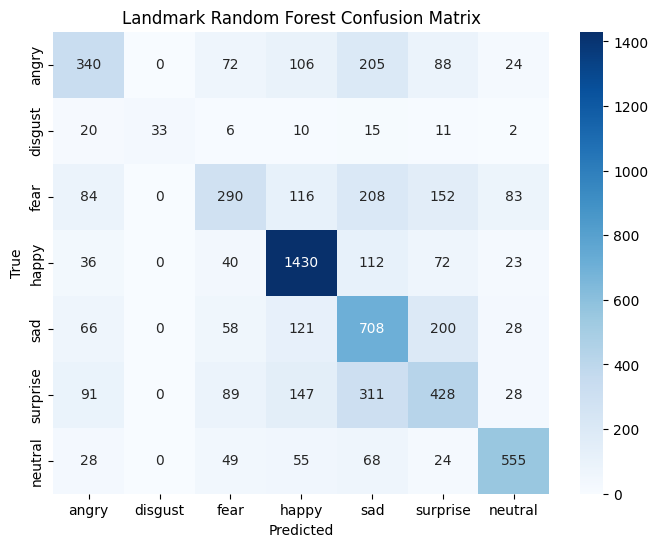

In [13]:
# --- TRACK A: Landmark Features Evaluation --- #
# Predictions
y_pred_landmark_rf = rf_landmark.predict(X_test_landmark)
y_pred_landmark_lr = logreg_landmark.predict(X_test_landmark_scaled)

# Accuracy and Macro-F1
acc_landmark_rf = accuracy_score(y_test_landmark, y_pred_landmark_rf)
f1_landmark_rf = f1_score(y_test_landmark, y_pred_landmark_rf, average='macro')

acc_landmark_lr = accuracy_score(y_test_landmark, y_pred_landmark_lr)
f1_landmark_lr = f1_score(y_test_landmark, y_pred_landmark_lr, average='macro')

print(f"Landmark Random Forest -> Accuracy: {acc_landmark_rf:.4f}, Macro-F1: {f1_landmark_rf:.4f}")
print(f"Landmark Logistic Regression -> Accuracy: {acc_landmark_lr:.4f}, Macro-F1: {f1_landmark_lr:.4f}\n")

# Classification report
print("Landmark Random Forest Classification Report:")
print(classification_report(y_test_landmark, y_pred_landmark_rf, digits=4))
print("Landmark Logistic Regression Classification Report:")
print(classification_report(y_test_landmark, y_pred_landmark_lr, digits=4))

# Confusion Matrix
cm_landmark_rf = confusion_matrix(y_test_landmark, y_pred_landmark_rf)
plt.figure(figsize=(8,6))
sns.heatmap(cm_landmark_rf, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title("Landmark Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

CNN Random Forest -> Accuracy: 0.4646, Macro-F1: 0.4392
CNN Logistic Regression -> Accuracy: 0.4248, Macro-F1: 0.3333

CNN Random Forest Classification Report:
              precision    recall  f1-score   support

       angry     0.4259    0.2161    0.2867       958
     disgust     1.0000    0.2703    0.4255       111
        fear     0.4531    0.2734    0.3410      1024
       happy     0.4527    0.7666    0.5693      1774
     neutral     0.4303    0.3852    0.4065      1233
         sad     0.3885    0.3913    0.3899      1247
    surprise     0.7279    0.5957    0.6552       831

    accuracy                         0.4646      7178
   macro avg     0.5541    0.4141    0.4392      7178
weighted avg     0.4745    0.4646    0.4476      7178

CNN Logistic Regression Classification Report:
              precision    recall  f1-score   support

       angry     0.2807    0.5052    0.3609       958
     disgust     1.0000    0.0090    0.0179       111
        fear     0.2715    0.4375

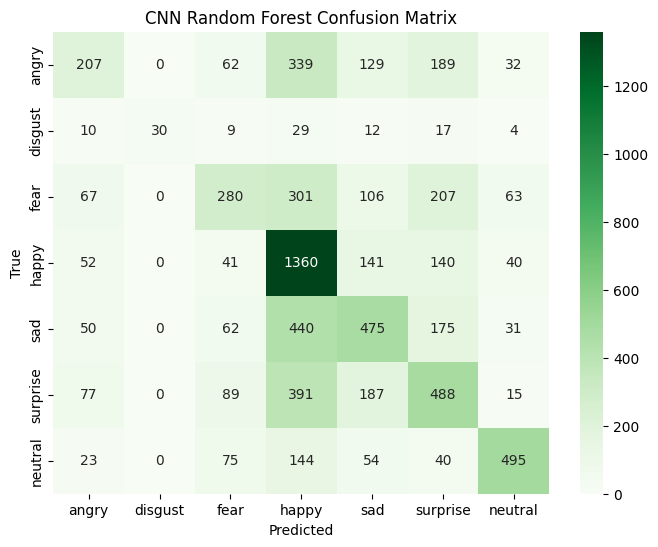

In [14]:
# --- TRACK B: CNN Features Evaluation --- #
# Predictions
y_pred_cnn_rf = rf_cnn.predict(X_test_cnn)
y_pred_cnn_lr = logreg_cnn.predict(X_test_cnn)  # if you trained logistic regression on CNN

# Accuracy and Macro-F1
acc_cnn_rf = accuracy_score(y_test_cnn, y_pred_cnn_rf)
f1_cnn_rf = f1_score(y_test_cnn, y_pred_cnn_rf, average='macro')

acc_cnn_lr = accuracy_score(y_test_cnn, y_pred_cnn_lr)
f1_cnn_lr = f1_score(y_test_cnn, y_pred_cnn_lr, average='macro')

print(f"CNN Random Forest -> Accuracy: {acc_cnn_rf:.4f}, Macro-F1: {f1_cnn_rf:.4f}")
print(f"CNN Logistic Regression -> Accuracy: {acc_cnn_lr:.4f}, Macro-F1: {f1_cnn_lr:.4f}\n")

# Classification report
print("CNN Random Forest Classification Report:")
print(classification_report(y_test_cnn, y_pred_cnn_rf, digits=4))
print("CNN Logistic Regression Classification Report:")
print(classification_report(y_test_cnn, y_pred_cnn_lr, digits=4))

# Confusion Matrix
cm_cnn_rf = confusion_matrix(y_test_cnn, y_pred_cnn_rf)
plt.figure(figsize=(8,6))
sns.heatmap(cm_cnn_rf, annot=True, fmt='d', cmap='Greens', xticklabels=classes, yticklabels=classes)
plt.title("CNN Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [15]:
def predict_emotion(img_path, use_cnn=True, model_type='rf'):
    img = cv2.imread(img_path)
    if img is None:
        print("Error: could not read image.")
        return

    if use_cnn:
        # --- CNN Feature Extraction ---
        img_resized = cv2.resize(img, (224, 224))
        img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
        x = img_to_array(img_rgb)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        feats = cnn_model.predict(x, verbose=0)
        feats_scaled = scaler_cnn.transform(feats)

        # Choose model
        if model_type == 'rf':
            pred = rf_cnn.predict(feats)
        else:
            pred = logreg_cnn.predict(feats_scaled)
        
        model_name = f"CNN + {'Random Forest' if model_type == 'rf' else 'Logistic Regression'}"
    else:
        # --- Landmark Feature Extraction ---
        feat = extract_landmark_features(img)
        if feat is None:
            print("No face detected.")
            return
        feat = feat.reshape(1, -1)
        feat_scaled = scaler_landmark.transform(feat)

        # Choose model
        if model_type == 'rf':
            pred = rf_landmark.predict(feat)
        else:
            pred = logreg_landmark.predict(feat_scaled)

        model_name = f"Landmark + {'Random Forest' if model_type == 'rf' else 'Logistic Regression'}"

    emotion = pred[0]
    print(f"{model_name}  predicted emotion: {pred[0]}")
    return emotion

In [17]:
test_img = "data_test/test2.jpg"

# Use CNN Random Forest
predict_emotion(test_img, use_cnn=True, model_type='rf')
predict_emotion(test_img, use_cnn=True, model_type='logreg')

# Use Landmark Logistic Regression
predict_emotion(test_img, use_cnn=False, model_type='rf')
predict_emotion(test_img, use_cnn=False, model_type='logreg')

CNN + Random Forest  predicted emotion: sad
CNN + Logistic Regression  predicted emotion: happy
Landmark + Random Forest  predicted emotion: happy
Landmark + Logistic Regression  predicted emotion: happy


'happy'

CNN + Random Forest  predicted emotion: angry
CNN + Logistic Regression  predicted emotion: sad
Landmark + Random Forest  predicted emotion: happy
Landmark + Logistic Regression  predicted emotion: angry


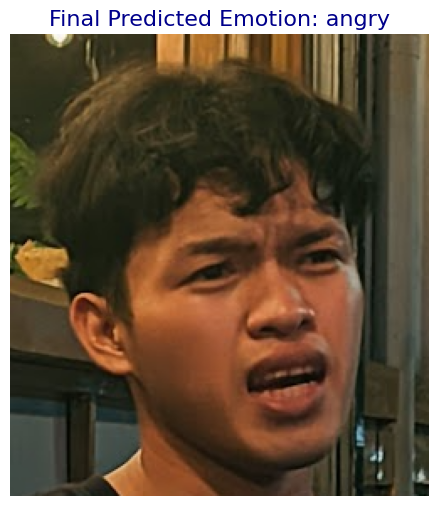

In [26]:
# Path
test_img = "data_test/test3.png"

# Predictions from all models
preds = [
    predict_emotion(test_img, use_cnn=True, model_type='rf'),
    predict_emotion(test_img, use_cnn=True, model_type='logreg'),
    predict_emotion(test_img, use_cnn=False, model_type='rf'),
    predict_emotion(test_img, use_cnn=False, model_type='logreg')
]

# Majority vote
final_prediction = Counter(preds).most_common(1)[0][0]

# Load and show
img = cv2.imread(test_img)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(6,6))
plt.imshow(img_rgb)
plt.axis('off')
plt.title(f"Final Predicted Emotion: {final_prediction}", fontsize=16, color='darkblue')
plt.show()